In [1]:
from modgen_utils import *
from modgen_classifier_models import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
### Titanic Classifier Testing Set

path = "/Users/jeromydiaz/Desktop/all/"
train = pd.read_csv("/Users/jeromydiaz/Desktop/all/train.csv")
test = pd.read_csv("/Users/jeromydiaz/Desktop/all/test.csv")

def titleCheck(x):
    # x[0] = name
    # x[1] = pclass
    important_title = ['Rev.', 'Dr.', 'Mme', 'Major', 'Lady', 'Sir.', 'Col.', 'Capt.', 'Countess']
    for title in important_title:
        if title in x[0] and x[1] == 1:
            return 1 
    return 0

##### Try Me 
test.fillna(test[test.Pclass == 3].Fare.mean(), inplace = True)

train['Under18P1'] = np.where((train['Age'] < 18) & (train['Pclass'] == 1), 1, 0)
train['Over60'] = np.where((train['Age'] > 60), 1, 0)
train['Alone'] = np.where((train['Parch'] == 0) & (train['SibSp'] == 0), 1, 0)
train['FareOver50'] = np.where((train['Fare'] > 50), 1, 0)
train['1stSpecial'] = train[['Name','Pclass']].apply(titleCheck, axis = 1)

test['Under18P1'] = np.where((test['Age'] < 18) & (test['Pclass'] == 1), 1, 0)
test['Over60'] = np.where((test['Age'] > 60), 1, 0)
test['Alone'] = np.where((test['Parch'] == 0) & (test['SibSp'] == 0), 1, 0)
test['FareOver50'] = np.where((test['Fare'] > 50), 1, 0)
test['1stSpecial'] = test[['Name','Pclass']].apply(titleCheck, axis = 1)

# For Train
y_train = train['Survived']
x_train = train.drop(['PassengerId','Survived','Name','Ticket','Cabin','Embarked', 'Parch', 'SibSp'], axis=1)
encSex = LabelEncoder()
testEnc = encSex.fit_transform(x_train.Sex)
x_train['Sex'] = testEnc
x_train['Age'].fillna(x_train.Age.mean(), inplace = True)

# For Test
x_test = test.drop(['PassengerId','Name','Ticket','Cabin','Embarked', 'Parch', 'SibSp'], axis=1)
x_test['Sex'] = encSex.fit_transform(x_test.Sex)
x_test['Age'].fillna(x_test.Age.mean(), inplace = True)

neuralnetwork


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


lightgbm


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))


xgboost


HBox(children=(IntProgress(value=0, max=1500), HTML(value='')))


lasso


HBox(children=(IntProgress(value=0, max=200), HTML(value='')))


ridge


HBox(children=(IntProgress(value=0, max=200), HTML(value='')))


knn


HBox(children=(IntProgress(value=0, max=200), HTML(value='')))


gradboost


HBox(children=(IntProgress(value=0, max=500), HTML(value='')))


svc


HBox(children=(IntProgress(value=0, max=250), HTML(value='')))

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)



decisiontree


HBox(children=(IntProgress(value=0, max=500), HTML(value='')))


randomforest


HBox(children=(IntProgress(value=0, max=200), HTML(value='')))


0.98104 0.830094


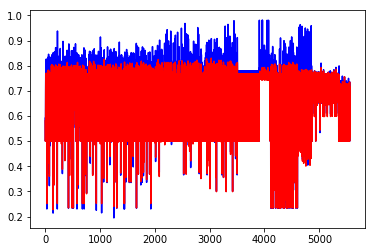

In [5]:

######## Model Options ########
### K-Fold Options
# 'normal', 'strat', 'normal_repeat', 'strat_repeat' - (type, # repeats)
use_kfold_CV = True
kfold_number_of_folds = 4
kfold_distribution = 'normal'
kfold_repeats = 1

### Scaler Option: StandardScaler(), Normalizer(), MinMaxScaler(), RobustScaler()
# If scaler_select = None, then no scaling will be done
scaler_select = StandardScaler()

### Model creation options
# If use_previous_model = False: Use new models_to_be_created dictionary to make models, else, use previous index to get parameters
# If train_test_submission = True: Train data on test set and make submission file of results
# If ensemble = True: Ensemble all previous index models together
use_previous_model = False
train_test_submission = False
ensemble = False

# Initialization of Lists and DFs
ensemble_predictions = []
analysis_DF = pd.DataFrame()
kfold_DF = pd.DataFrame()
params = {}
total_models = 0

if use_previous_model:
    params, model_selector, model_selector_mod = getSavedParams(load_index = 150)
    models_to_be_created = {model_selector : 1}
else:
    models_to_be_created = {
                        'neuralnetwork': 5,
                        'lightgbm'     : 2000,
                        'xgboost'      : 1500,
                        'lasso'        : 200,
                        'ridge'        : 200,
                        'knn'          : 200,
                        'gradboost'    : 500,
                        'svc'          : 250,
                        'decisiontree' : 500,
                        'randomforest' : 200
                    }

### K-Fold Cross Validation Inputs
# If a prevous_model is being loaded, then it automatically turns off kfold_CV
if use_previous_model: use_kfold_CV = False
if use_kfold_CV:
    kfold_type = (kfold_distribution, kfold_repeats)
else:
    kfold_number_of_folds = 1
    kfold_type = None

### Scaler Function Inputs
if scaler_select:
    X_train, X_test = scaleSelector(x_train, x_test, scaler_select)
else:
    X_train, X_test = x_train, x_test
Y_train, X_valid, Y_valid = y_train, None, None

# If kfold_number_of_folds == 1: Split the data using train_test_split
if kfold_number_of_folds <= 1:
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, random_state = 5)

# Model Function:
#      Linear: LinearRegression(), LogisticRegression(), Perceptron(), Ridge(), Lasso()
#      Ensemble: RandomForestClassifier(), AdaBoostClassifier(), GradientBoostingClassifier()
#      Tree: DecisionTreeClassifier()
#      Neighbors: KNeighborsClassifier()
#      SVM: SVC()

# Random Seed
np.random.seed()

for model_selector, number_of_models in models_to_be_created.items():
    total_models += number_of_models
    print(model_selector)
    for _ in tqdm(range(0,number_of_models)):

        if model_selector == 'lightgbm':
            params, model = getModelLightGBM(use_previous_model, params)

        elif model_selector == 'xgboost':
            params, model = getModelXGBoost(use_previous_model, params)

        elif model_selector == 'neuralnetwork':
            params, model = getModelNeuralNetwork(use_previous_model, params)

        elif model_selector == 'lasso':
            # Lasso Model Generator
            params, model = getModelLasso(use_previous_model, params)

        elif model_selector == 'ridge':
            # Ridge Model Generator
            params, model = getModelLasso(use_previous_model, params)

        elif model_selector == 'knn':
            # KNN Model Generator
            params, model = getModelKNN(use_previous_model, params)

        elif model_selector == 'gradboost':
            # Gradient Boosting Generator
            params, model = getModelGradientBoosting(use_previous_model, params)

        elif model_selector == 'svc':
            # SVC Model Generator
            params, model = getModelSVC(use_previous_model, params)

        elif model_selector == 'adaboost':
            # AdaBoost with DecisionTreeClassifier Model Generator
            params, model = getModelAdaBoostTree(use_previous_model, params)

        elif model_selector == 'decisiontree':
            # DecisionTreeClassifier Model Generator
            params, model = getModelDecisionTree(use_previous_model, params)

        elif model_selector == 'randomforest':
            # RandomForest Model Generator
            params, model = getModelRandomForest(use_previous_model, params)


        # Model Generation based off paramList and modelList
        Pred_train, Pred_valid, Pred_test, kfold_DF = modelSelector(X_train, Y_train, X_valid, Y_valid,
                                                                    X_test, params, train_test_submission, model, kfold_number_of_folds = kfold_number_of_folds,
                                                                    kfold_type = kfold_type, modeltype = model_selector)

        analysis_DF = dataFrameUpdate(params, Y_train, Y_valid, Pred_train, Pred_valid, analysis_DF, kfold_DF,
                                    use_kfold_CV)
        if ensemble: ensemble_predictions.append(Pred_test)


if kfold_number_of_folds > 1:
    train_auc = analysis_DF['Train Auc'].apply(lambda x: x.split('-')[0].strip()).astype('float64')
    valid_auc = analysis_DF['Valid Auc'].apply(lambda x: x.split('-')[0].strip()).astype('float64')
else:
    train_auc = analysis_DF['Train Auc']
    valid_auc = analysis_DF['Valid Auc']

print(train_auc.max(), valid_auc.max())
plt.plot(range(0, total_models), train_auc, 'b', label = 'Train Auc')
plt.plot(range(0, total_models), valid_auc, 'r', label = 'Valid Auc')
plt.show()
if not use_previous_model:
    analysis_DF = analysis_DF.sort_values(['Valid Auc','Train Auc'], ascending = False)
    analysis_DF.to_csv('//Users/jeromydiaz/Desktop/Titanic_AnalysisDF.csv')

# Writes final submission file
if train_test_submission: trainFullSubmission(Pred_test, test['PassengerId'], ensemble, ensemble_predictions)

In [4]:
analysis_DF.sort_values(['Valid Auc','Train Auc'], ascending = False)

,Model_type,Train Accuracy,Train Auc,Train Loss,Valid Accuracy,Valid Auc,Valid Loss,batch_size,epoch,kernel_initializer,...,gamma,min_child_weight,alpha,n_neighbors,p,min_samples_leaf,min_samples_split,C,degree,kernel
4409,gradboost,0.929641,0.918471,0.070359,0.883408,0.860542,0.116592,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.122423,0.400706,NaN,NaN,NaN
1265,lightgbm_gbdt,0.893713,0.880635,0.106287,0.878924,0.856971,0.121076,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1454,lightgbm_gbdt,0.878743,0.864162,0.121257,0.878924,0.856971,0.121076,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
744,lightgbm_gbdt,0.869760,0.853995,0.130240,0.878924,0.856971,0.121076,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
343,lightgbm_gbdt,0.893713,0.879927,0.106287,0.874439,0.853399,0.125561,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
582,lightgbm_gbdt,0.833832,0.814035,0.166168,0.874439,0.853399,0.125561,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3189,xgboost,0.938623,0.930762,0.061377,0.878924,0.852065,0.121076,NaN,NaN,NaN,...,1e-05,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1912,lightgbm_gbdt,0.907186,0.893053,0.092814,0.874439,0.848494,0.125561,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1106,lightgbm_rf,0.833832,0.818283,0.166168,0.869955,0.847375,0.130045,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1924,lightgbm_gbdt,0.829341,0.805411,0.170659,0.874439,0.846041,0.125561,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
